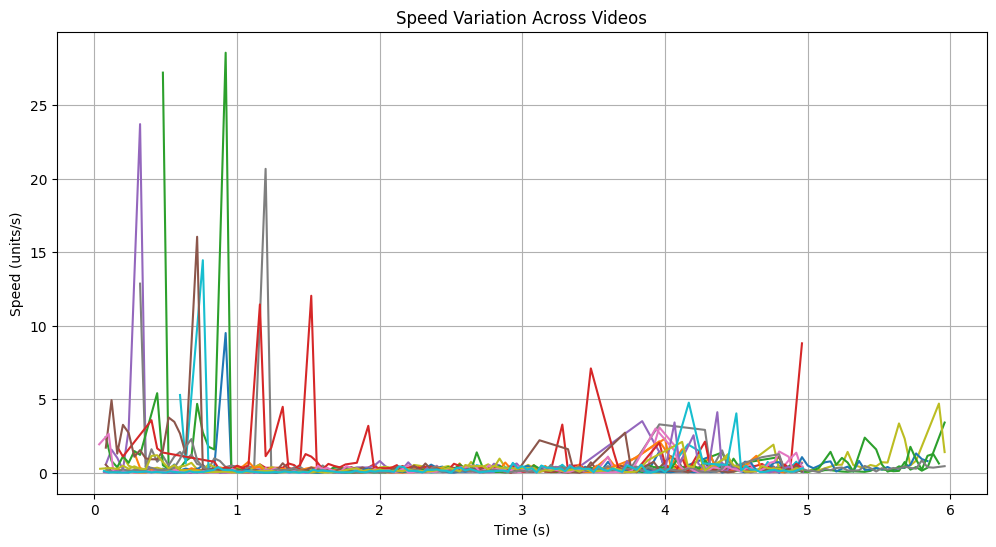

In [4]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os

# Initialize Mediapipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

def process_video(video_path):
    """Process a single video to extract speed variation."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time per frame

    positions = []  # Store landmark positions (e.g., hips center)
    timestamps = []  # Store corresponding timestamps

    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to RGB (Mediapipe requires RGB input)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process frame with Mediapipe Pose
        results = pose.process(rgb_frame)

        if results.pose_landmarks:
            # Extract key landmarks (e.g., hips)
            left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]

            # Compute center of hips
            center_hip_x = (left_hip.x + right_hip.x) / 2
            center_hip_y = (left_hip.y + right_hip.y) / 2

            # Store position and timestamp
            positions.append((center_hip_x, center_hip_y))
            timestamps.append(frame_index * frame_time)

        frame_index += 1

    cap.release()

    # Calculate speed
    speeds = []
    for i in range(1, len(positions)):
        dx = positions[i][0] - positions[i - 1][0]
        dy = positions[i][1] - positions[i - 1][1]
        displacement = np.sqrt(dx**2 + dy**2)
        speed = displacement / frame_time  # Speed in units/frame time
        speeds.append(speed)

    return timestamps[1:], speeds

def plot_speeds_from_folder(folder_path):
    """Process all videos in a folder and plot speed graphs together."""
    video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    plt.figure(figsize=(12, 6))

    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        timestamps, speeds = process_video(video_path)

        # Plot speed for the current video
        plt.plot(timestamps, speeds, label=os.path.basename(video_file))

    # Graph settings
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (units/s)")
    plt.title("Speed Variation Across Videos")
    plt.grid()
    plt.show()

# Specify the folder containing the videos
folder_path = "vid"
plot_speeds_from_folder(folder_path)


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


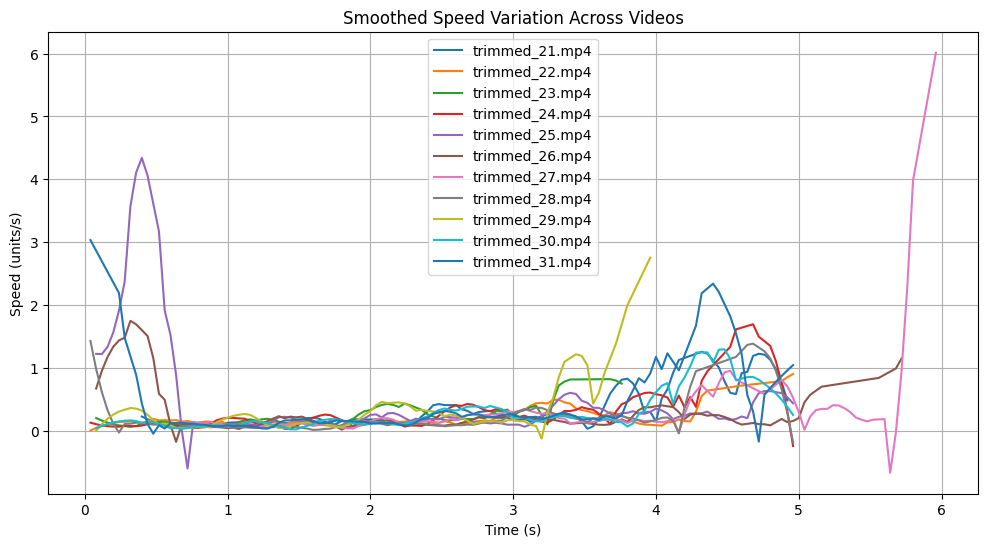

Feature matrix saved to features1.csv


In [12]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter, find_peaks
import pandas as pd

# Initialize Mediapipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

def process_video(video_path, smoothing=True):
    """Process a single video to extract speed variation."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time per frame

    positions = []  # Store landmark positions (e.g., hips center)
    timestamps = []  # Store corresponding timestamps

    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to RGB (Mediapipe requires RGB input)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process frame with Mediapipe Pose
        results = pose.process(rgb_frame)

        if results.pose_landmarks:
            # Extract key landmarks (e.g., hips)
            left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]

            # Compute center of hips
            center_hip_x = (left_hip.x + right_hip.x) / 2
            center_hip_y = (left_hip.y + right_hip.y) / 2

            # Store position and timestamp
            positions.append((center_hip_x, center_hip_y))
            timestamps.append(frame_index * frame_time)

        frame_index += 1

    cap.release()

    if len(positions) < 2:
        return [], []  # Not enough data to calculate speed

    # Calculate speed
    speeds = []
    for i in range(1, len(positions)):
        dx = positions[i][0] - positions[i - 1][0]
        dy = positions[i][1] - positions[i - 1][1]
        displacement = np.sqrt(dx**2 + dy**2)
        speed = displacement / frame_time  # Speed in units/frame time
        speeds.append(speed)

    # Apply smoothing if requested and data is sufficient
    if smoothing and len(speeds) > 11:  # Window size for smoothing must be smaller than data length
        speeds = savgol_filter(speeds, window_length=11, polyorder=2)

    return timestamps[1:], speeds

def extract_features(timestamps, speeds):
    """Extract features from speed data."""
    if len(speeds) == 0:  # Check for empty speed data
        return {
            "mean_speed": 0,
            "max_speed": 0,
            "std_speed": 0,
            "mean_acceleration": 0,
            "max_acceleration": 0,
            "num_peaks": 0,
        }

    # Statistical features
    mean_speed = np.mean(speeds)
    max_speed = np.max(speeds)
    std_speed = np.std(speeds)

    # Acceleration features
    accelerations = np.diff(speeds) / (timestamps[1] - timestamps[0]) if len(timestamps) > 1 else []
    mean_acceleration = np.mean(accelerations) if len(accelerations) > 0 else 0
    max_acceleration = np.max(accelerations) if len(accelerations) > 0 else 0

    # Peaks
    peaks, _ = find_peaks(speeds, height=0.5)  # Peaks above a threshold
    num_peaks = len(peaks)

    return {
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "std_speed": std_speed,
        "mean_acceleration": mean_acceleration,
        "max_acceleration": max_acceleration,
        "num_peaks": num_peaks,
    }

def plot_smoothed_speeds_from_folder(folder_path):
    """Process all videos in a folder and plot smoothed speed graphs together."""
    video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    plt.figure(figsize=(12, 6))

    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        timestamps, speeds = process_video(video_path)

        if len(timestamps) > 0 and len(speeds) > 0:
            # Plot smoothed speeds
            plt.plot(timestamps, speeds, label=os.path.basename(video_file))

    # Graph settings
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (units/s)")
    plt.title("Smoothed Speed Variation Across Videos")
    plt.legend()
    plt.grid()
    plt.show()

def generate_feature_matrix(folder_path, output_csv="features.csv"):
    """Process all videos, extract features, and save as a CSV for ML."""
    video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    feature_list = []

    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        timestamps, speeds = process_video(video_path)
        features = extract_features(timestamps, speeds)
        features["video"] = video_file
        feature_list.append(features)

    # Save to CSV
    feature_matrix = pd.DataFrame(feature_list)
    feature_matrix.to_csv(output_csv, index=False)
    print(f"Feature matrix saved to {output_csv}")

# Main script
if __name__ == "__main__":
    folder_path = "vdnt"  # Replace with your folder path
    output_csv = "features1.csv"

    # Plot all smoothed speed graphs
    plot_smoothed_speeds_from_folder(folder_path)

    # Generate and save feature matrix
    generate_feature_matrix(folder_path, output_csv=output_csv)
